In [1]:
import numpy as np 
from itertools import chain, combinations
from scipy.sparse import *
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# $\lambda_i^j$ i.i.d

In [2]:
def steady_state(Lambda, msg=None):
    n = len(Lambda)
    C = np.concatenate((Lambda[0:n-1,:] - Lambda[1:n,:], np.ones((1,n))), axis=0)
    det = np.linalg.det(C)
    if det == 0: 
        if msg : print('Encore du travail !')
        return []
    b = np.zeros((n,1))
    b[n-1] = 1
    Xsol = np.linalg.solve(C,b)
    if len(Xsol[Xsol < 0])>=1:
        if msg : print('Pas de solution positive')
        return []
    else : 
        if msg : print('Solution de coexistence')
        return Xsol

In [3]:
def Jac(z, Lambda):
    assert len(Lambda) != 0 
    n = len(Lambda)
    z = np.reshape(z,(n,1))
    JAC_coex = np.diag(z.T[0])@(Lambda - np.ones((n,n))@np.diag(np.array((Lambda + Lambda.T)@z).T[0]))
    bloc = np.array((Lambda)@z -((z.T)@Lambda@z)).T[0]
    JAC_trivial = np.diag(bloc)
    return JAC_coex + JAC_trivial

In [4]:
def Jac_red(z, Lambda):
    "Jacobian Matrix for a given system at a given point z reducted to the simplexe sum(z_i)=1"
    assert len(Lambda) != 0 
    n = len(Lambda)
    P = np.concatenate((np.ones((1,n)),np.concatenate((np.ones((n-1,1)),-np.eye(n-1)),axis=1)),axis=0)
    JAC = Jac(z,Lambda)
    JACnew = np.linalg.inv(P)@JAC@P
    return JACnew[1:,1:]

In [5]:
def stab(Lambda, z):
    "Stability of steady state z for a given system FIT"
    M = Jac_red(z, Lambda)
    VP = np.linalg.eig(M)[0]
    U = -1
    for v in VP:
        if v > 0: U =  1
        if (v == 0 & U == -1): U = 0
    return U

In [6]:
def stab_val(Lambda, z):
    "Maximum eigenvalue of the Jacobian of a steady state z for a given system FIT"
    M = Jac_red(z, Lambda)
    VP = np.linalg.eig(M)[0]
    return np.max(VP.real)

In [7]:
def classification_test(Lambda):
    """For the system defined by FIT or by (A and mu), 
    this function compute all the positive steady states and their stability.
    
    the output is a list of dictionnaries : one for each positive steady state.
    A given dictionnary dict has the following entries :
    -- 'steady' : the value of the steady state z
    -- 'type' : the number of non zero coefficients in z. This gives the number of species which are living at z. 
    -- 'nature' : an integer coding the nature of z. 1 for unstable, -1 for asymptoticaly stable and  0 for stable.
    -- 'eigen' : the real part of the maximum eigenvalue of the jacobian matrix at z.
    """
    assert len(Lambda) != 0
    N = len(Lambda)
    Liste_Big_dico = []
    
    for r in range(1, N + 1):
        for I in combinations(range(N), r):
            I = list(I)
            Lambdasub = np.zeros((len(I),len(I)))
            for i in range(len(I)):
                for j in range(len(I)):
                    Lambdasub[i,j] = Lambda[I[i],I[j]]
            zsub = steady_state(Lambdasub)
            if len(zsub) > 0:
                z = np.zeros((N,1))
                z[I] = zsub
                nat = stab(Lambda, z=np.array(z))
                zs = z.reshape(N).tolist()
                eig = stab_val(Lambda, z=np.array(z))
                dico = {'steady':zs ,'type':len(I) ,'nature':nat,'eigen':eig}
                Liste_Big_dico.append(dico)
    return Liste_Big_dico

In [8]:
def generate_matrix(N, mean=0, var=1):
    Lambda = np.random.normal(mean, np.sqrt(var), (N,N))
    np.fill_diagonal(Lambda, 0)
    return Lambda

In [9]:
def mat(Lambda):
    N = len(Lambda)
    resultats = classification_test(Lambda)
    n_row = 2**N - 1
    n_col = N
    sparse_mat = lil_matrix((n_row, n_col), dtype=float)
    i = 0
    for res in resultats:
        Z = res['steady']
        stab = res['nature']  
        
        if stab == -1: 
            if i >= n_row:
                break
            
            sparse_mat[i, :] = Z
            i += 1
    
    sparse_mat = sparse_mat.tocsr()
    
    return sparse_mat

In [10]:
def mat_bin(Lambda):
    "Matrice binaire des états"
    M = mat(Lambda)
    M_bin = M.copy()
    M_bin.data = np.ones_like(M_bin.data)
    return M_bin

In [12]:
M = 10000

In [13]:
N_values = range(2, 11)

## Average number of stable steady states

In [15]:
def av(M, N_values, mean=0, var=1):
    av_SSS = []
    for N in N_values:
        S_Lambda = 0
        for _ in range(M):
            Lambda = generate_matrix(N, mean=0, var=1)
            SSS = mat(Lambda)
            sum_non_nuls = SSS.sum(axis=1).A1
            sum_non_nuls = sum_non_nuls[sum_non_nuls>0]
            S_Lambda += len(sum_non_nuls)
        S_Lambda /= M
        av_SSS.append(S_Lambda)
    plt.plot(N_values, av_SSS, marker='o', linestyle='-', color='b')    
    plt.xlabel('N')
    plt.ylabel('Average number of stable steady states')
    plt.grid(True)
    plt.show()

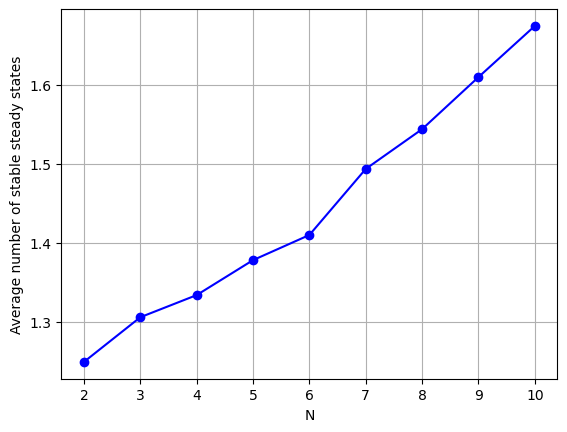

In [17]:
av(M, N_values, mean=0, var=1)

## Probability of having a stable steady state with k strains

In [18]:
def F_Lambda_0(Lambda):
    N = len(Lambda)
    M_bin = mat_bin(Lambda)
    sum_non_nuls = M_bin.sum(axis=1).A1
    sum_non_nuls = sum_non_nuls[sum_non_nuls > 0]
    unique_sums, S_Lambda_k = np.unique(sum_non_nuls, return_counts=True)
    S_Lambda = len(sum_non_nuls)
    if S_Lambda == 0:
        return [0 for i in range(N)], 0
    LS_Lambda = [0 for i in range(N)]
    for val, count in zip(unique_sums, S_Lambda_k):
        LS_Lambda[int(val)-1] = count
    
    LS_Lambda = np.array(LS_Lambda)/S_Lambda
    LS_Lambda = LS_Lambda.tolist()
    return LS_Lambda, S_Lambda

In [19]:
def F(M, N):
    data = []
    no_stable_count = 0
    for i in range(M):
        Lambda = generate_matrix(N, mean=0, var=1)
        LS_Lambda, S_Lambda = F_Lambda_0(Lambda)
        if S_Lambda == 0:
            no_stable_count += 1
        data.append(LS_Lambda)
    data = np.array(data)
    data = data[~np.all(data == 0, axis=1)]
    return data, no_stable_count

In [20]:
def histogram_0(M, N, alpha=0.05):
    data, no_stable_count = F(M, N)
    m_k_strains = data.mean(axis=0)
    v_k_strains = data.var(axis=0)
    
    m_k_strains = np.insert(m_k_strains, 0, no_stable_count / M)
    v_k_strains = np.insert(v_k_strains, 0, 0)  
    
    m_k_strains /= m_k_strains.sum()

    Mean = [0 for i in range(N + 1)]
    for i, (m, v) in enumerate(zip(m_k_strains, v_k_strains), start=0):
        m_v = v / M
        LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
        m = np.round(m, 3)
        v = np.round(v, 3)
        LCL = np.round(LCL, 3)
        UCL = np.round(UCL, 3)
        # print("Moyenne pour %s souche: %s"%(i, m))
        # print("Variance pour %s souche: %s"%(i, v))
        # print("Intervalle de confiance de niveau asymptotique 0.95 pour %s souche: [%s, %s]"%(i, LCL, UCL))
        # print('\n')
        Mean[i] = m
    
    plt.bar(range(0, N+1), Mean)
    plt.xticks(range(0, N+1))
    plt.xlabel('k')
    plt.ylabel('Probability that a stable steady state has k strains')
    plt.title('N = %s'%N)
    plt.show()

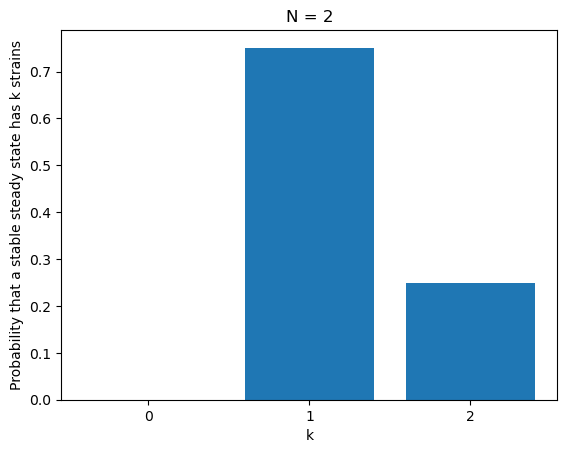

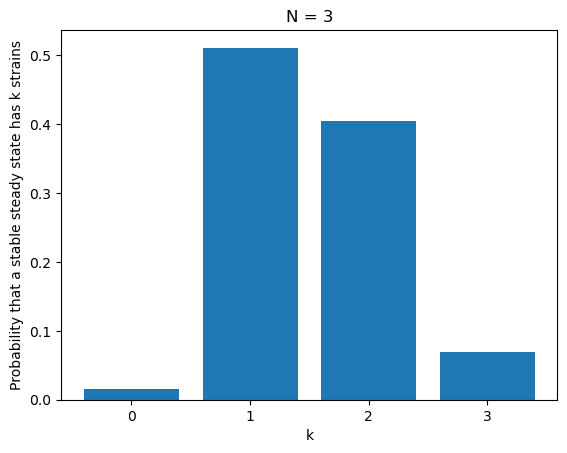

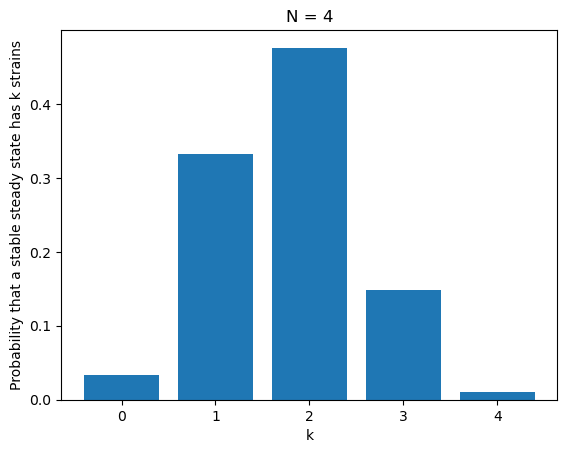

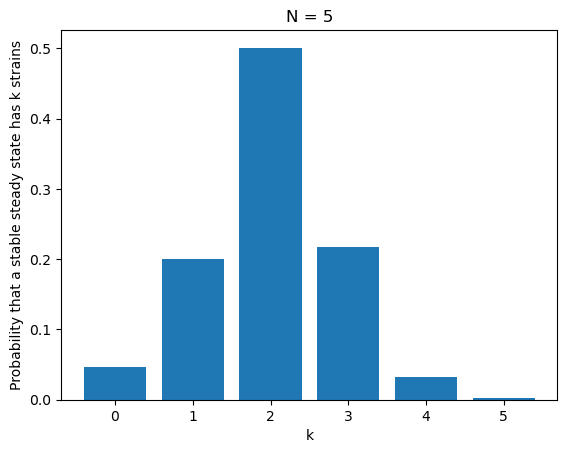

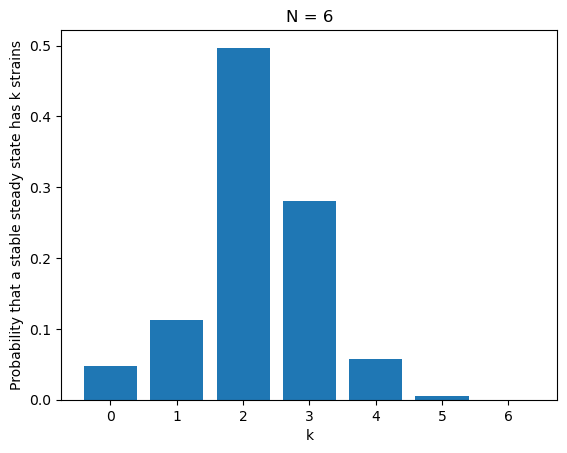

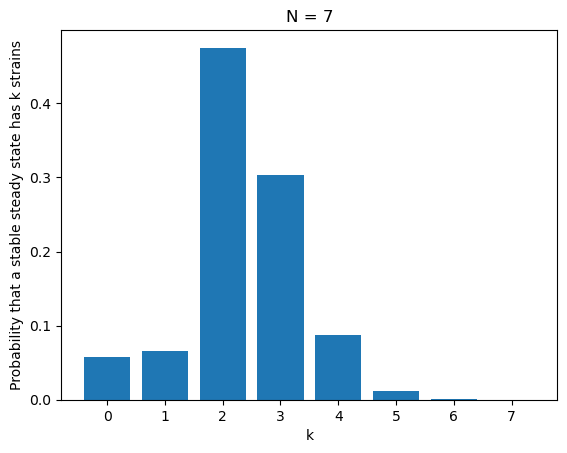

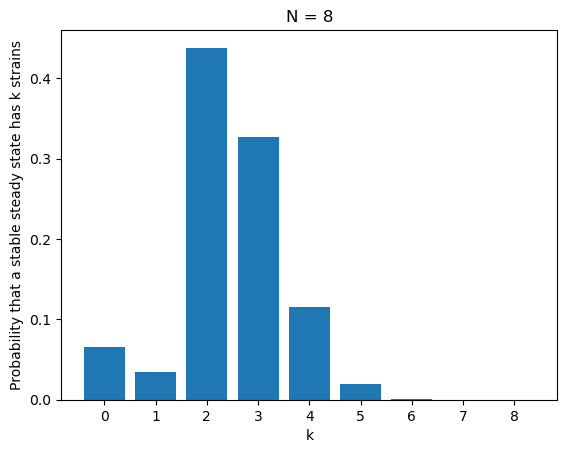

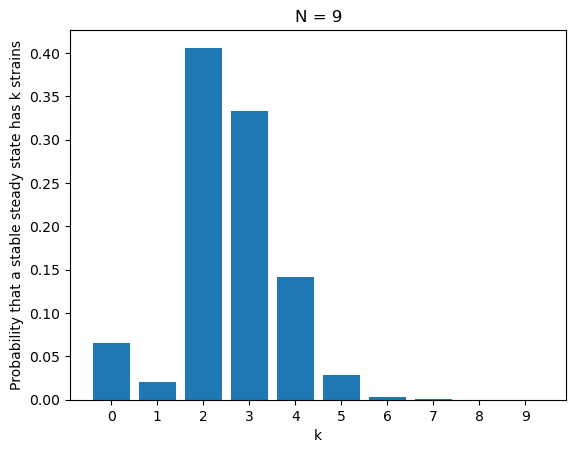

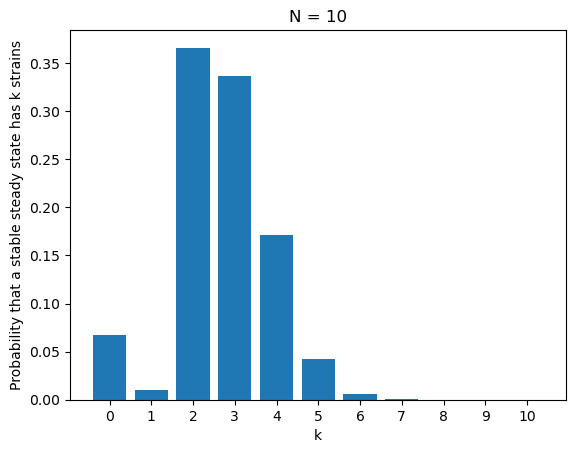

In [25]:
for N in N_values:
    histogram_0(10000, N, alpha=0.05)

In [26]:
def histogram_sub(M, N_values):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
    axs_flat = axs.flatten()
    
    for ax, N in zip(axs_flat, N_values):
        data, no_stable_count = F(M, N)
        m_k_strains = data.mean(axis=0)

        m_k_strains = np.insert(m_k_strains, 0, no_stable_count / M)

        m_k_strains /= m_k_strains.sum()

        ax.bar(range(0, N+1), m_k_strains)
        ax.set_xticks(range(0, N+1))
        ax.set_title('N = %s'%N)
        
    fig.text(0.04, 0.5, 'Probability that a stable steady state has k strains', va='center', rotation='vertical')
    fig.text(0.5, 0.04, 'k', va='center', ha='center')
    plt.show()

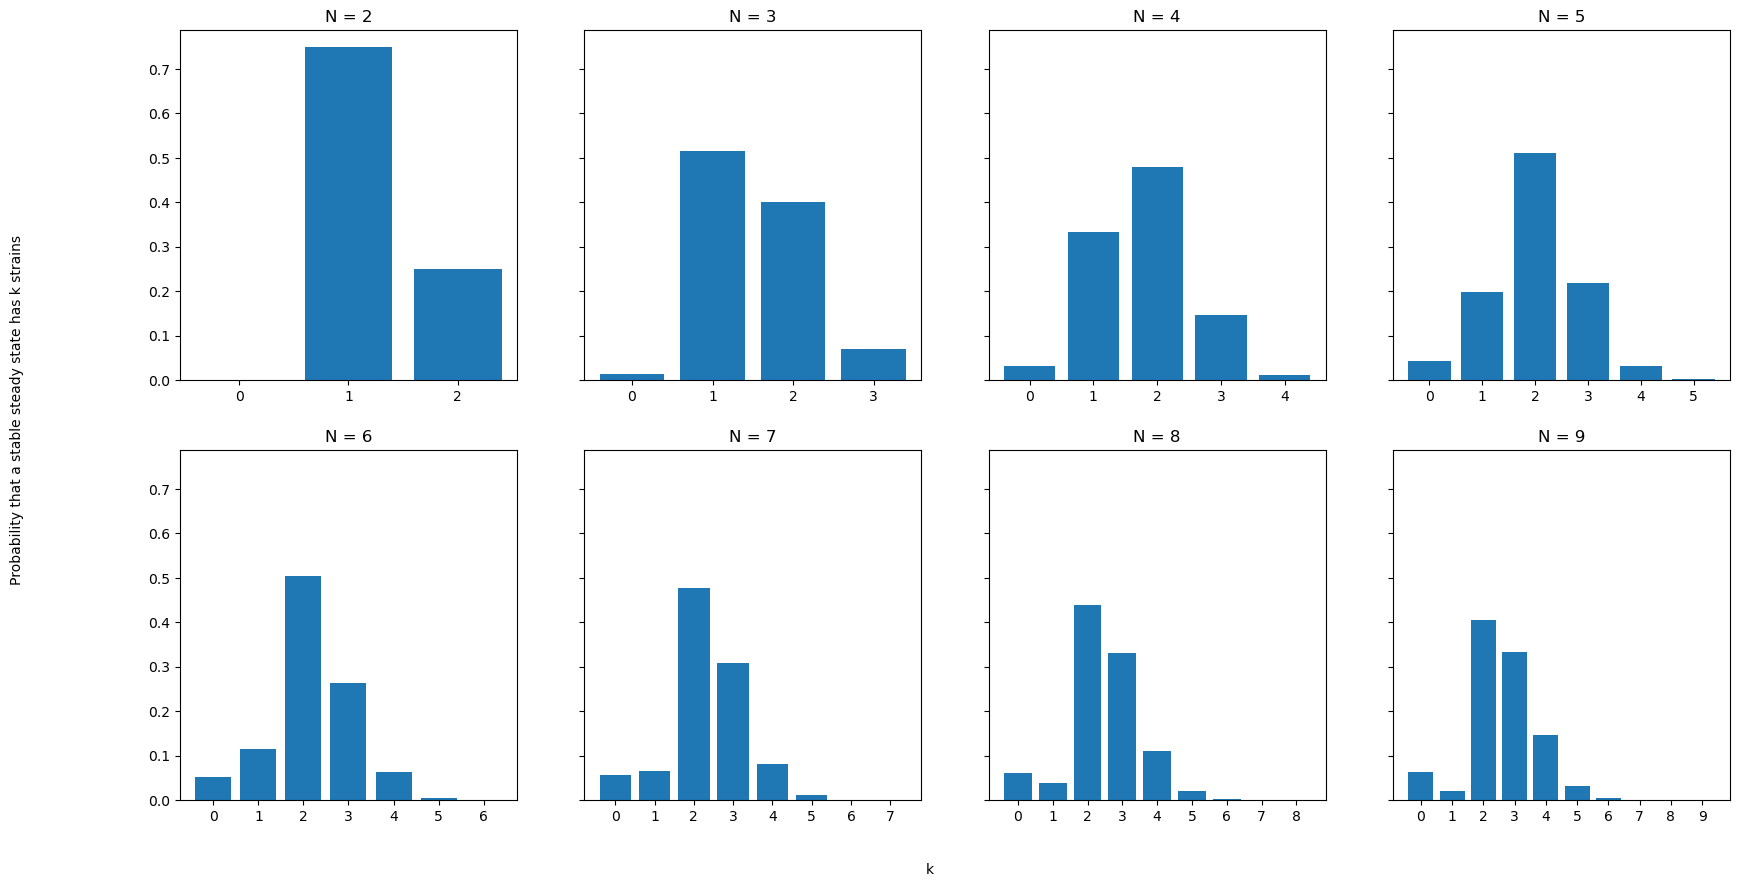

In [27]:
histogram_sub(M, N_values)

In [28]:
def histogram_sub_cumul(M, N_values):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
    axs_flat = axs.flatten()
    for ax, N in zip(axs_flat, N_values):
        data, no_stable_count = F(M, N)
        m_k_strains = data.mean(axis=0)
        m_k_strains = np.insert(m_k_strains, 0, no_stable_count / M)
        m_k_strains /= m_k_strains.sum()
        bar_width = 0.5
        x = np.arange(1)
        bottom = 0
        
        for k in range(len(m_k_strains)):
            ax.bar(x, m_k_strains[k], bar_width, bottom=bottom, label=f'k = {k}')
            bottom += m_k_strains[k]

        ax.set_xticks([])
        ax.set_xlim(-0.7, 0.7)
        ax.set_title(f'N={N}')
        ax.legend()

    fig.text(0.04, 0.5, 'Probability that a stable steady state has k strains', va='center', rotation='vertical')
    plt.show()

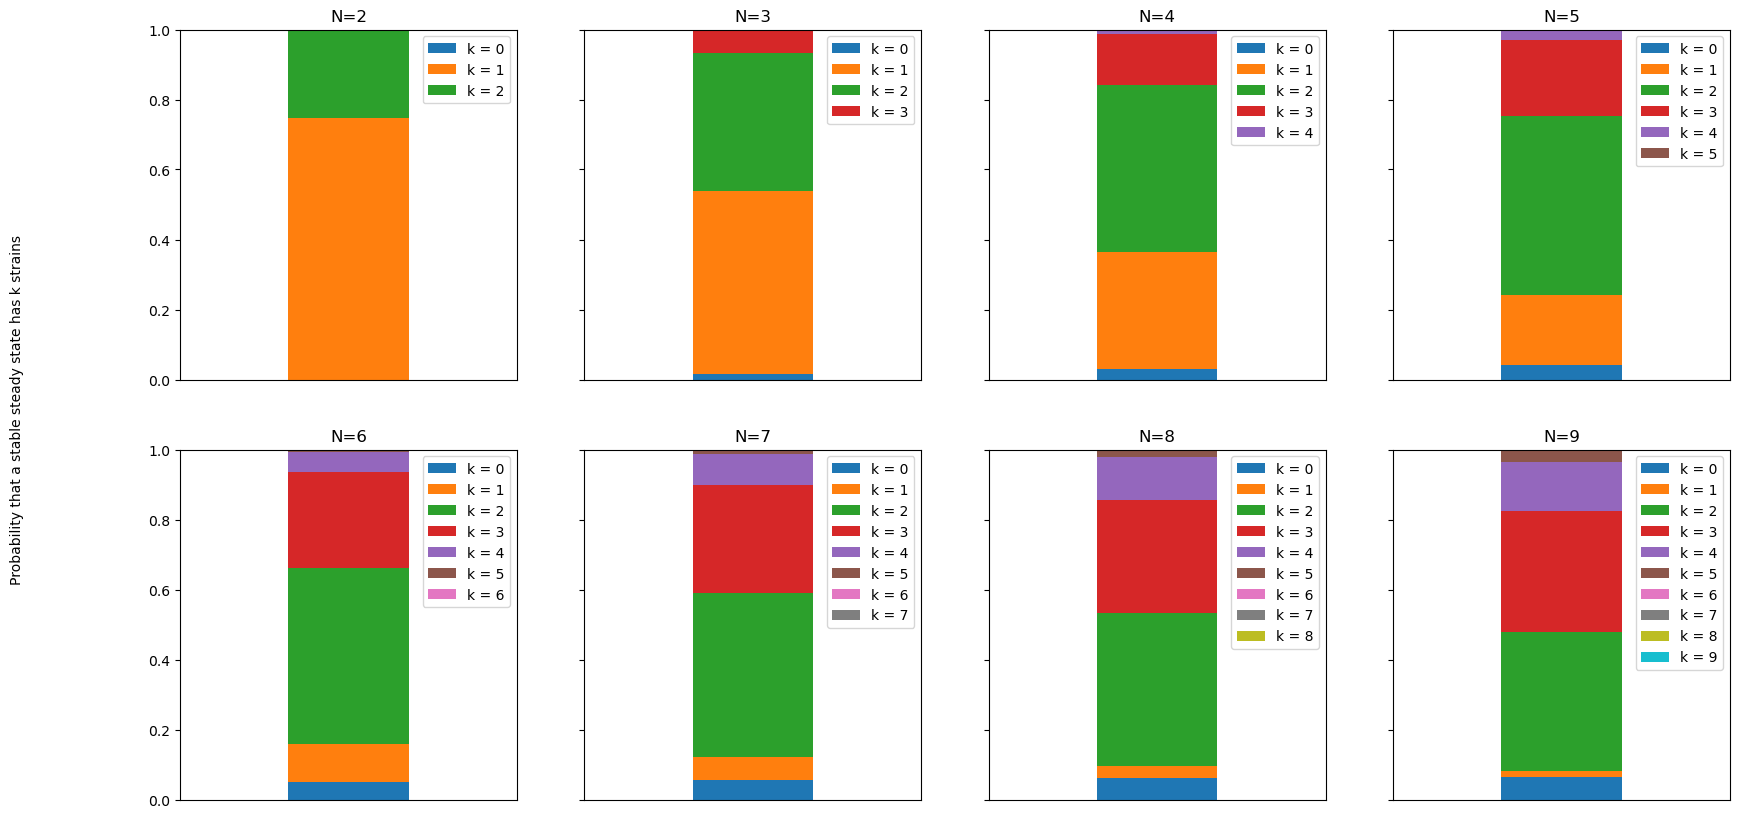

In [29]:
 histogram_sub_cumul(M, N_values)

## Average of stable steady states with k strains

In [30]:
def exp_k(Lambda):
    N = len(Lambda)
    M_bin = mat_bin(Lambda)
    sum_non_nuls = M_bin.sum(axis=1).A1
    sum_non_nuls = sum_non_nuls[sum_non_nuls > 0]
    unique_sums, S_Lambda_k = np.unique(sum_non_nuls, return_counts=True)
    S_Lambda = len(sum_non_nuls)
    LS_Lambda = [0 for i in range(N)]
    for val, count in zip(unique_sums, S_Lambda_k):
        LS_Lambda[int(val)-1] = count
    return LS_Lambda

In [31]:
def exp(M, N, mean=0, var=1):
    data = []
    for i in range(M):
        Lambda = generate_matrix(N, mean=0, var=1)
        LS_Lambda = exp_k(Lambda)
        data.append(LS_Lambda)
    data = np.array(data)
    return data

In [32]:
def plot_exp_k(M, N_values, mean=0, var=1, alpha=0.05):
    assert len(N_values) >= 5
    plot_E = []
    for N in N_values:
        data = exp(M, N, mean=0, var=1)
        m_k_strains = data.mean(axis=0)
        v_k_strains = data.var(axis=0)
        i = 0
        Mean = np.zeros(len(N_values)+1)
        for m, v in zip(m_k_strains, v_k_strains):
            i += 1
            m_v = v / M
            LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
            m = np.round(m, 3)
            v = np.round(v, 3)
            LCL = np.round(LCL, 3)
            UCL = np.round(UCL, 3)
            # print("Mean for %s strains: %s"%(i, m))
            # print("Variance for %s strains: %s"%(i, v))
            # print("0.95 confidence interval for %s strains: [%s, %s]"%(i, LCL, UCL))
            # print('\n')
            Mean[i-1] = m
        plot_E.append(Mean)
    plot_E = np.array(plot_E)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for k in range(5):
        plt.plot(N_values, plot_E[:, k], color=colors[k], label=f'k={k+1}')
    plt.ylabel('Average of stable steady states with k strains')
    plt.xlabel('N')
    plt.legend()
    plt.grid(True)
    plt.show()

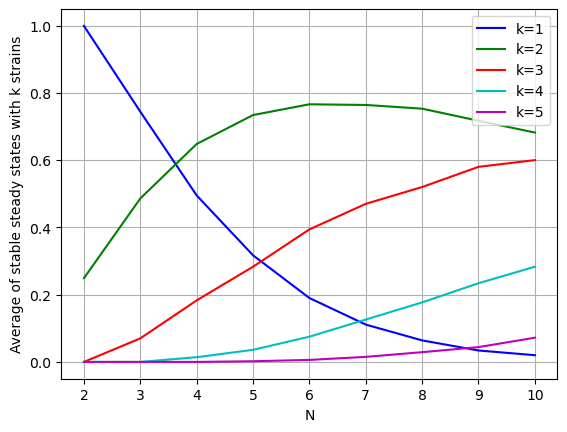

In [34]:
plot_exp_k(M, N_values, mean=0, var=1, alpha=0.05)

# $\lambda_i^j = \alpha_{ji} - \alpha_{jj} - \mu (\alpha_{ij} - \alpha_{ji})$

In [35]:
def steady_state(A,mu=1,msg=None):
    """Computation of the steady_states of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    mat=mu*(A.T-A)+A.T
    C=np.concatenate( (mat[0:n-1,:]-mat[1:n,:],np.ones((1,n))), axis=0)
    det=np.linalg.det(C)
    if det==0: 
        if msg : print('Encore du travail !')
        return None 
    b=np.zeros((n,1))
    b[n-1]=1
    Xsol=np.linalg.solve(C,b)
    if len(Xsol[Xsol<0])>=1:
        if msg : print('Pas de solution positive')
        return None
    else : 
        if msg : print('Solution de coexistence')
        return Xsol

In [36]:
def fitness(A,mu=1):
    """Computation of the fitness of the reducted model.
    A is the matrix of interaction and mu is the ratio I/II
    """
    n=len(A)
    return mu*(A.T-A)+A.T-np.matrix(np.ones((n,1)))*np.matrix(np.diagonal(A))


In [37]:
def steady_state_fit(FIT,msg=None):
    """Computation of the steady_state using the fitness
    """
    n=len(FIT)        
    C=np.concatenate((np.ones((1,n)),(FIT[0:n-1,:]-FIT[1:n,:])), axis=0)
    det=np.linalg.det(C)
    if det==0: 
        if msg : print('Encore du travail !')
        return []
    b=np.zeros((n,1))
    b[0]=1
    Xsol=np.linalg.solve(C,b)
    if len(Xsol[Xsol<0])>=1:
        if msg : print('Pas de solution positive')
        return []
    else : 
        if msg : print('Solution de coexistence')
        return Xsol

In [38]:
def classification_test_mu(A=[],mu=1,FIT=[]):
    """For the system defined by FIT or by (A and mu), 
    this function compute all the positive steady states and their stability.
    
    the output is a list of dictionnaries : one for each positive steady state.
    A given dictionnary dict has the following entries :
    -- 'steady' : the value of the steady state z
    -- 'type' : the number of non zero coefficients in z. This gives the number of species which are living at z. 
    -- 'nature' : an integer coding the nature of z. 1 for unstable, -1 for asymptoticaly stable and  0 for stable.
    -- 'eigen' : the real part of the maximum eigenvalue of the jacobian matrix at z.
    """
    assert len(A)+len(FIT)!=0
    if len(FIT)==0:
        FIT=fitness(A,mu)
    N=len(FIT)
    Liste_Big_dico=[]

    for r in range(1, N + 1):
        for I in combinations(range(N), r):
            I = list(I)
            FITsub = np.zeros((len(I),len(I)))
            for i in range(len(I)):
                for j in range(len(I)):
                    FITsub[i,j] = FIT[I[i],I[j]]
            zsub = steady_state_fit(FITsub)
            if len(zsub) > 0:
                z = np.zeros((N,1))
                z[I] = zsub
                nat = stab(FIT, z=np.array(z))
                zs = z.reshape(N).tolist()
                eig = stab_val(FIT, z=np.array(z))
                dico = {'steady':zs ,'type':len(I) ,'nature':nat,'eigen':eig}
                Liste_Big_dico.append(dico)
    return Liste_Big_dico

In [39]:
def generate_A(N, mean=0, var=1):
    A = np.random.normal(mean, np.sqrt(var), (N,N))
    return A

In [47]:
def mat_mu(A, mu=1):
    N = len(A)
    resultats = classification_test_mu(A,mu,FIT=[])
    n_row = 2**N - 1
    n_col = N
    sparse_mat = lil_matrix((n_row, n_col), dtype=float)
    i = 0
    for res in resultats:
        Z = res['steady']
        stab = res['nature']  
        
        if stab == -1: 
            if i >= n_row:
                break
            
            sparse_mat[i, :] = Z
            i += 1
    
    sparse_mat = sparse_mat.tocsr()
    
    return sparse_mat

In [60]:
def mat_bin_mu(A, mu=1):
    "Matrice binaire des états"
    M = mat_mu(A, mu)
    M_bin = M.copy()
    M_bin.data = np.ones_like(M_bin.data)
    return M_bin

In [61]:
M = 10000

In [62]:
N_values = range(2, 11)

In [63]:
mu_values = [0, 0.01, 0.1, 1, 10]

## Average number of stable steady states

In [52]:
def av_mu(M, N_values, mu_values, mean=0, var=1):
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i, mu in enumerate(mu_values):
        av_SSS = []
        for N in N_values:
            S_Lambda = 0
            for _ in range(M):
                A = generate_A(N, mean=0, var=1)
                SSS = mat_mu(A, mu)
                sum_non_nuls = SSS.sum(axis=1).A1
                sum_non_nuls = sum_non_nuls[sum_non_nuls>0]
                S_Lambda += len(sum_non_nuls)
            S_Lambda /= M
            av_SSS.append(S_Lambda)
        print(av_SSS)
        plt.plot(N_values, av_SSS, marker='o', linestyle='-', color=colors[i], label='$\mu=%s$'%mu)    
    plt.xlabel('N')
    plt.ylabel('Average number of stable steady states')
    plt.legend()
    plt.grid(True)
    plt.show()

[1.2529, 1.4372, 1.5996, 1.7385, 1.8631, 1.9773, 2.0833, 2.1881, 2.2611]
[1.2509, 1.4323, 1.5815, 1.7112, 1.8289, 1.9624, 2.0603, 2.1565, 2.2315]
[1.2282, 1.4002, 1.5032, 1.6024, 1.6876, 1.7547, 1.8294, 1.8719, 1.9309]
[1.1319, 1.1345, 1.0691, 1.0087, 0.9484, 0.8821, 0.8162, 0.7462, 0.6864]
[1.0227, 0.9066, 0.7879, 0.6794, 0.5922, 0.5088, 0.4443, 0.3746, 0.327]


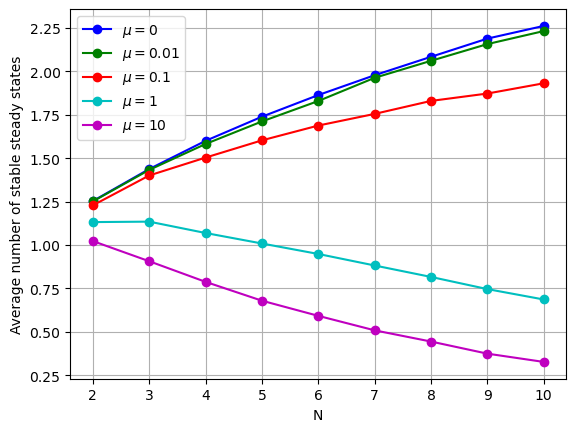

In [54]:
av_mu(M, N_values, mu_values, mean=0, var=1)

## Probability of having a stable steady state with k strains

In [69]:
def F_Lambda_0_mu(A, mu):
    N = len(A)
    M_bin = mat_bin_mu(A, mu)
    sum_non_nuls = M_bin.sum(axis=1).A1
    sum_non_nuls = sum_non_nuls[sum_non_nuls > 0]
    unique_sums, S_Lambda_k = np.unique(sum_non_nuls, return_counts=True)
    S_Lambda = len(sum_non_nuls)
    if S_Lambda == 0:
        return [0 for i in range(N)], 0
    LS_Lambda = [0 for i in range(N)]
    for val, count in zip(unique_sums, S_Lambda_k):
        LS_Lambda[int(val)-1] = count
    
    LS_Lambda = np.array(LS_Lambda)/S_Lambda
    LS_Lambda = LS_Lambda.tolist()
    return LS_Lambda, S_Lambda

In [70]:
def F_mu(M, mu, N):
    data = []
    no_stable_count = 0
    for i in range(M):
        A = generate_A(N, mean=0, var=1)
        LS_Lambda, S_Lambda = F_Lambda_0_mu(A, mu)
        if S_Lambda == 0:
            no_stable_count += 1
        data.append(LS_Lambda)
    data = np.array(data)
    data = data[~np.all(data == 0, axis=1)]
    return data, no_stable_count

In [71]:
def histogram_0_mu(M, N, mu, alpha=0.05):
    data, no_stable_count = F_mu(M, mu, N)
    m_k_strains = data.mean(axis=0)
    v_k_strains = data.var(axis=0)
    
    m_k_strains = np.insert(m_k_strains, 0, no_stable_count / M)
    v_k_strains = np.insert(v_k_strains, 0, 0)  
    
    m_k_strains /= m_k_strains.sum()

    Mean = [0 for i in range(N + 1)]
    for i, (m, v) in enumerate(zip(m_k_strains, v_k_strains), start=0):
        m_v = v / M
        LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
        m = np.round(m, 3)
        v = np.round(v, 3)
        LCL = np.round(LCL, 3)
        UCL = np.round(UCL, 3)
        # print("Moyenne pour %s souche: %s"%(i, m))
        # print("Variance pour %s souche: %s"%(i, v))
        # print("Intervalle de confiance de niveau asymptotique 0.95 pour %s souche: [%s, %s]"%(i, LCL, UCL))
        # print('\n')
        Mean[i] = m
    
    plt.bar(range(0, N+1), Mean)
    plt.xticks(range(0, N+1))
    plt.xlabel('k')
    plt.ylabel('Probability that a stable steady state has k strains')
    plt.title('N = %s'%N)
    plt.show()

In [72]:
def plot_cumulative(N, mu_values, M, mean=0, var=1):
    data = []
    for mu in mu_values:
        data_s, no_stable_count = F_mu(M, mu, N)
        m_k_strains = data_s.mean(axis=0)
        m_k_strains = np.insert(m_k_strains, 0, no_stable_count / M)
        m_k_strains /= m_k_strains.sum()
        data.append(m_k_strains)
    data = np.array(data)
    data = data.T
    fig, ax = plt.subplots()
    bar_width = 0.5
    x = np.arange(len(mu_values))
    bottom = np.zeros(len(mu_values))
    for k in range(N+1):
        ax.bar(x, data[k], bar_width, bottom=bottom, label=f'k = {k}')
        bottom += data[k]

    ax.set_xlabel('$\mu$')
    ax.set_ylabel('Probability that a stable steady state has k strains')
    ax.set_title(f'N = {N}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mu}' for mu in mu_values])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

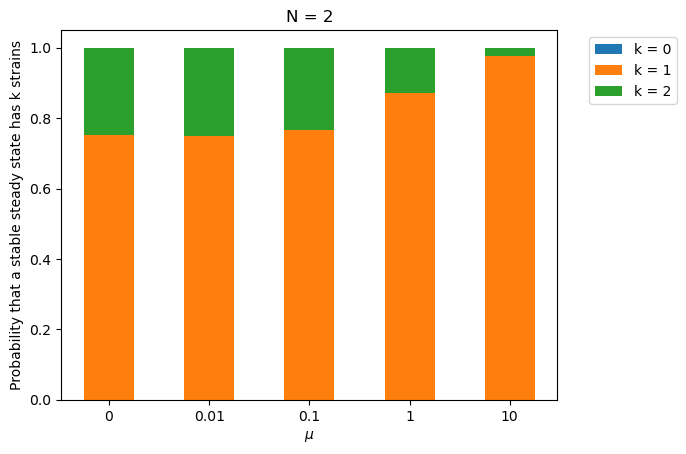

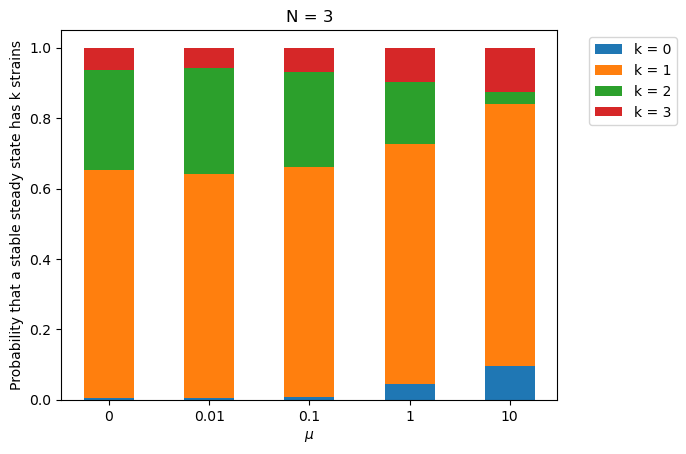

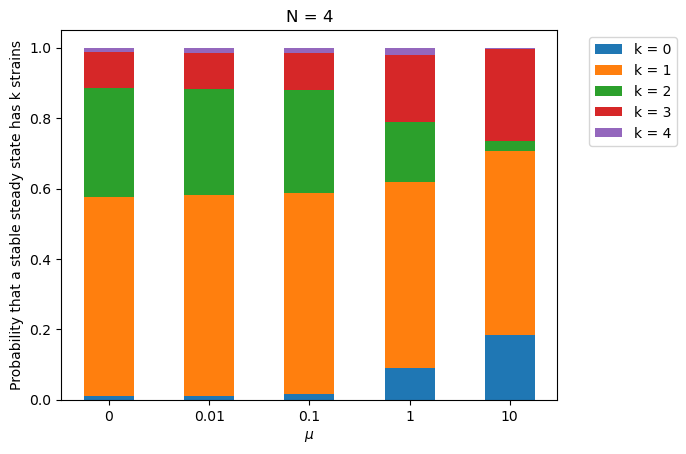

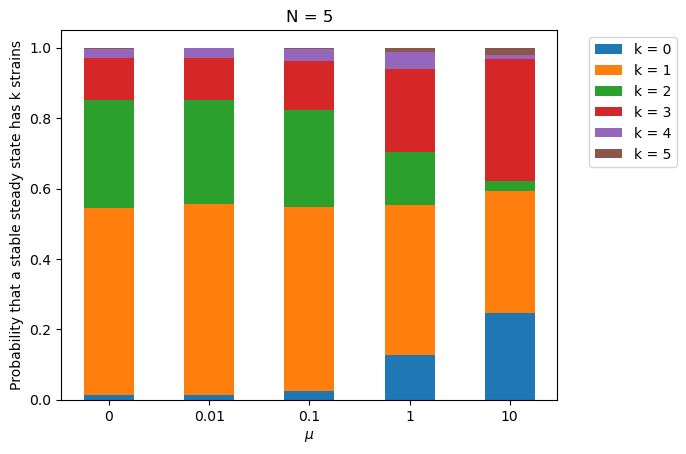

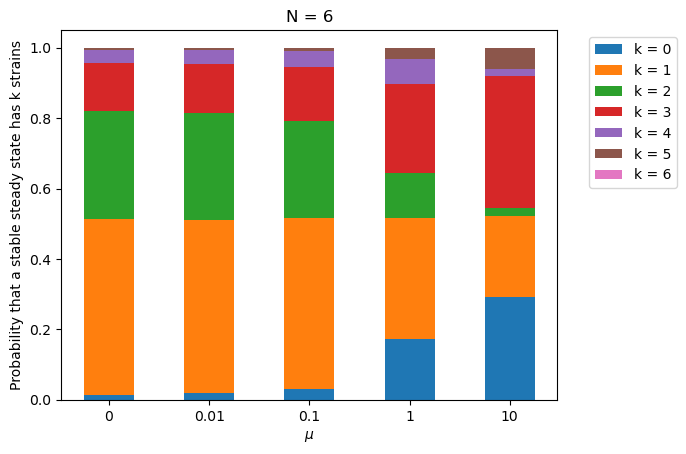

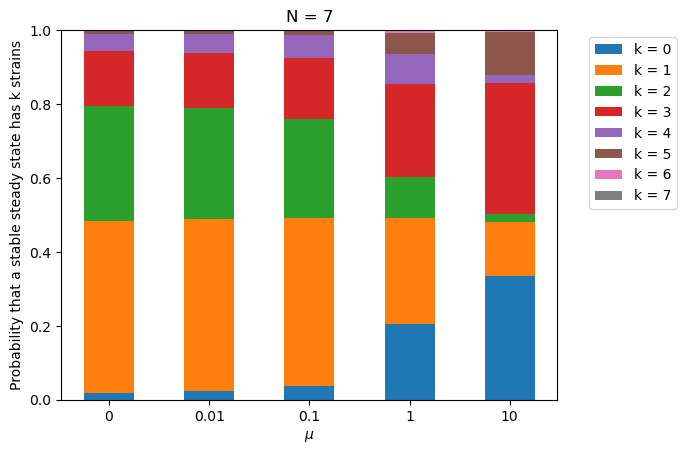

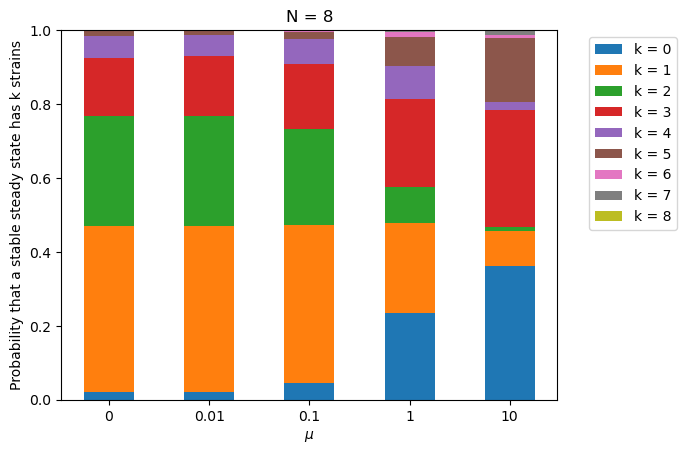

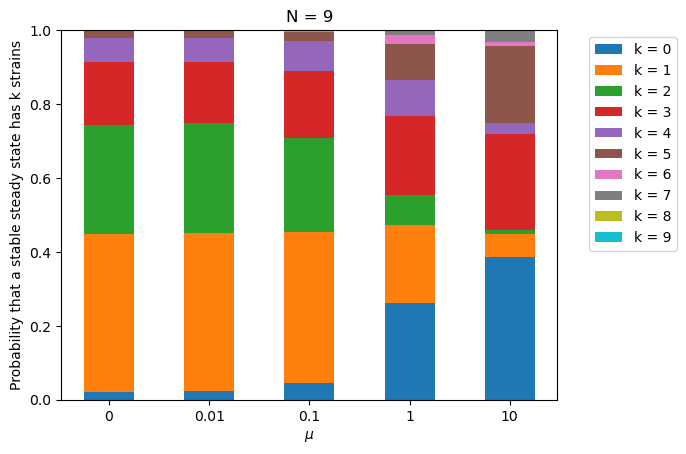

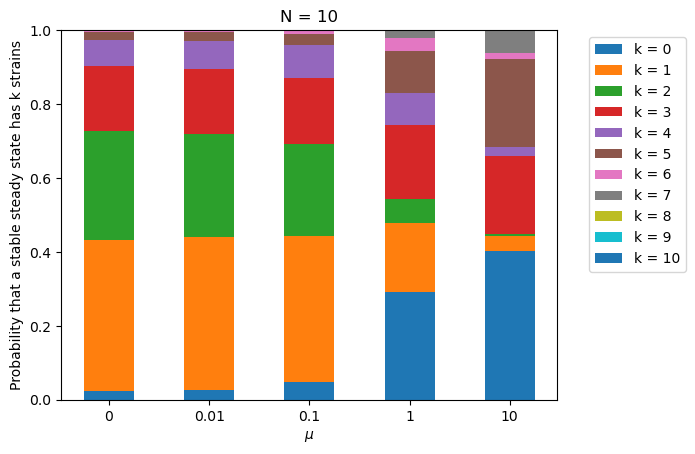

In [75]:
for N in N_values:
    plot_cumulative(N, mu_values, M, mean=0, var=1)

## Average of stable steady states with k strains

In [76]:
def exp_k_mu(A, mu):
    N = len(A)
    M_bin = mat_bin_mu(A, mu)
    sum_non_nuls = M_bin.sum(axis=1).A1
    sum_non_nuls = sum_non_nuls[sum_non_nuls > 0]
    unique_sums, S_Lambda_k = np.unique(sum_non_nuls, return_counts=True)
    S_Lambda = len(sum_non_nuls)
    LS_Lambda = [0 for i in range(N)]
    for val, count in zip(unique_sums, S_Lambda_k):
        LS_Lambda[int(val)-1] = count
    return LS_Lambda

In [77]:
def exp_mu(M, N, mu, mean=0, var=1):
    data = []
    for i in range(M):
        A = generate_A(N, mean=0, var=1)
        LS_Lambda = exp_k_mu(A, mu)
        data.append(LS_Lambda)
    data = np.array(data)
    return data

In [78]:
def plot_exp_k(M, N_values, mu, mean=0, var=1, alpha=0.05):
    assert len(N_values) >= 5
    plot_E = []
    for N in N_values:
        data = exp_mu(M, N, mu, mean=0, var=1)
        m_k_strains = data.mean(axis=0)
        v_k_strains = data.var(axis=0)
        i = 0
        Mean = np.zeros(len(N_values)+1)
        for m, v in zip(m_k_strains, v_k_strains):
            i += 1
            m_v = v / M
            LCL, UCL = m + st.norm.isf([1 - alpha/2, alpha/2]) * np.sqrt(m_v)
            m = np.round(m, 3)
            v = np.round(v, 3)
            LCL = np.round(LCL, 3)
            UCL = np.round(UCL, 3)
            # print("Mean for %s strains: %s"%(i, m))
            # print("Variance for %s strains: %s"%(i, v))
            # print("0.95 confidence interval for %s strains: [%s, %s]"%(i, LCL, UCL))
            # print('\n')
            Mean[i-1] = m
        plot_E.append(Mean)
    plot_E = np.array(plot_E)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for k in range(5):
        plt.plot(N_values, plot_E[:, k], color=colors[k], label=f'k={k+1}')
    plt.ylabel('Average of stable steady states with k strains')
    plt.xlabel('N')
    plt.title('$\mu$=%s'%mu)
    plt.legend()
    plt.grid(True)
    plt.show()

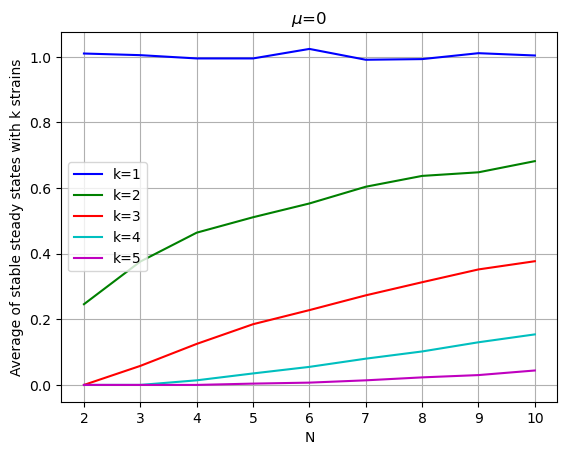

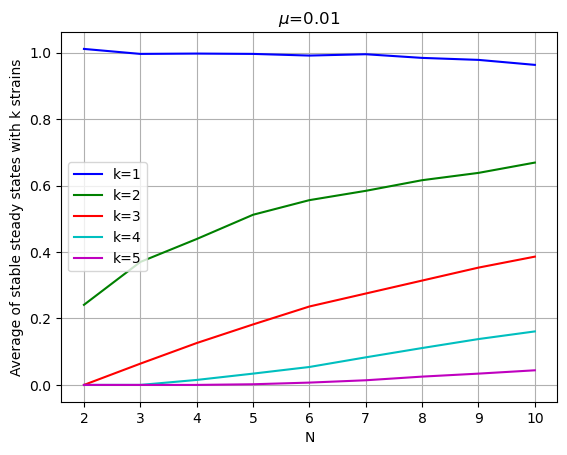

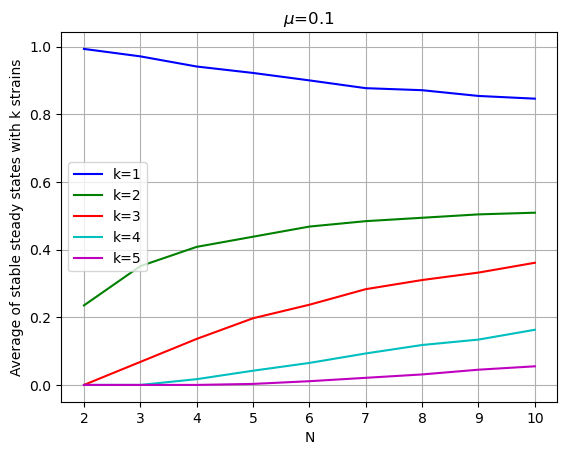

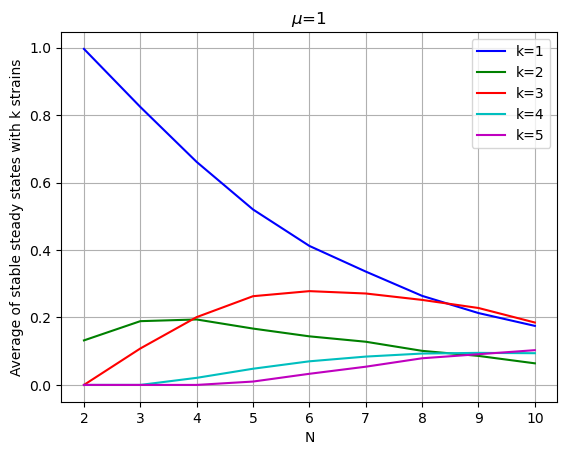

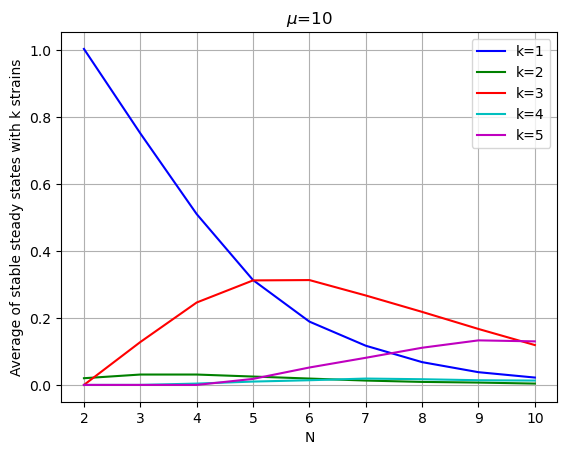

In [79]:
for mu in mu_values:
    plot_exp_k(M, N_values, mu, mean=0, var=1, alpha=0.05)